# Parametric fit

Checking if a simple parametric model can be a good fit for the wear curves.

In [1]:
from itertools import zip_longest

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

import matplotlib.pyplot as plt

## Data loading

In [2]:
dset = pd.read_csv("../results/dataset_minutes.csv")
dset

,material,sample,Time [min],Line Distance [m],Wear Loss [mm]
0,G1,S1,0,0.118,-0.001950
1,G1,S1,1,0.358,-0.000967
2,G1,S1,2,0.598,-0.001717
3,G1,S1,3,0.838,-0.000992
4,G1,S1,4,1.078,-0.001683
...,...,...,...,...,...
236802,G9,S5,4162,998.998,0.162267
236803,G9,S5,4163,999.238,0.164275
236804,G9,S5,4164,999.478,0.163733
236805,G9,S5,4165,999.718,0.163325


## Models fitting and prediction

In [3]:
def fit_huber(group):
    X = group["Line Distance [m]"].values[:, None]
    y = group["Wear Loss [mm]"].values
    model = HuberRegressor().fit(X, y)
    ypred = model.predict(X)
    return ypred


def fit_log1p(group):
    X = group["Line Distance [m]"].values
    X = np.stack([X, np.log1p(X), np.ones(len(X))], axis=1)
    y = group["Wear Loss [mm]"].values
    model = LinearRegression(positive=True, fit_intercept=False)
    model.fit(X, y)
    ypred = model.predict(X)
    return ypred


def fit_logistic(group):
    X = group["Line Distance [m]"].values[:, None]
    y = group["Wear Loss [mm]"].values

    model = make_pipeline(
        StandardScaler(),
        MLPRegressor(hidden_layer_sizes=(1,), activation="logistic", solver="lbfgs"),
    )
    best_score = -np.inf

    for _ in range(50):
        candidate = clone(model)
        candidate.fit(X, y)
        if (score := candidate.score(X, y)) > best_score:
            model = candidate
            best_score = score

    ypred = model.predict(X)
    return ypred

In [4]:
models = {"huber": fit_huber, "log1p": fit_log1p, "logistic": fit_logistic}

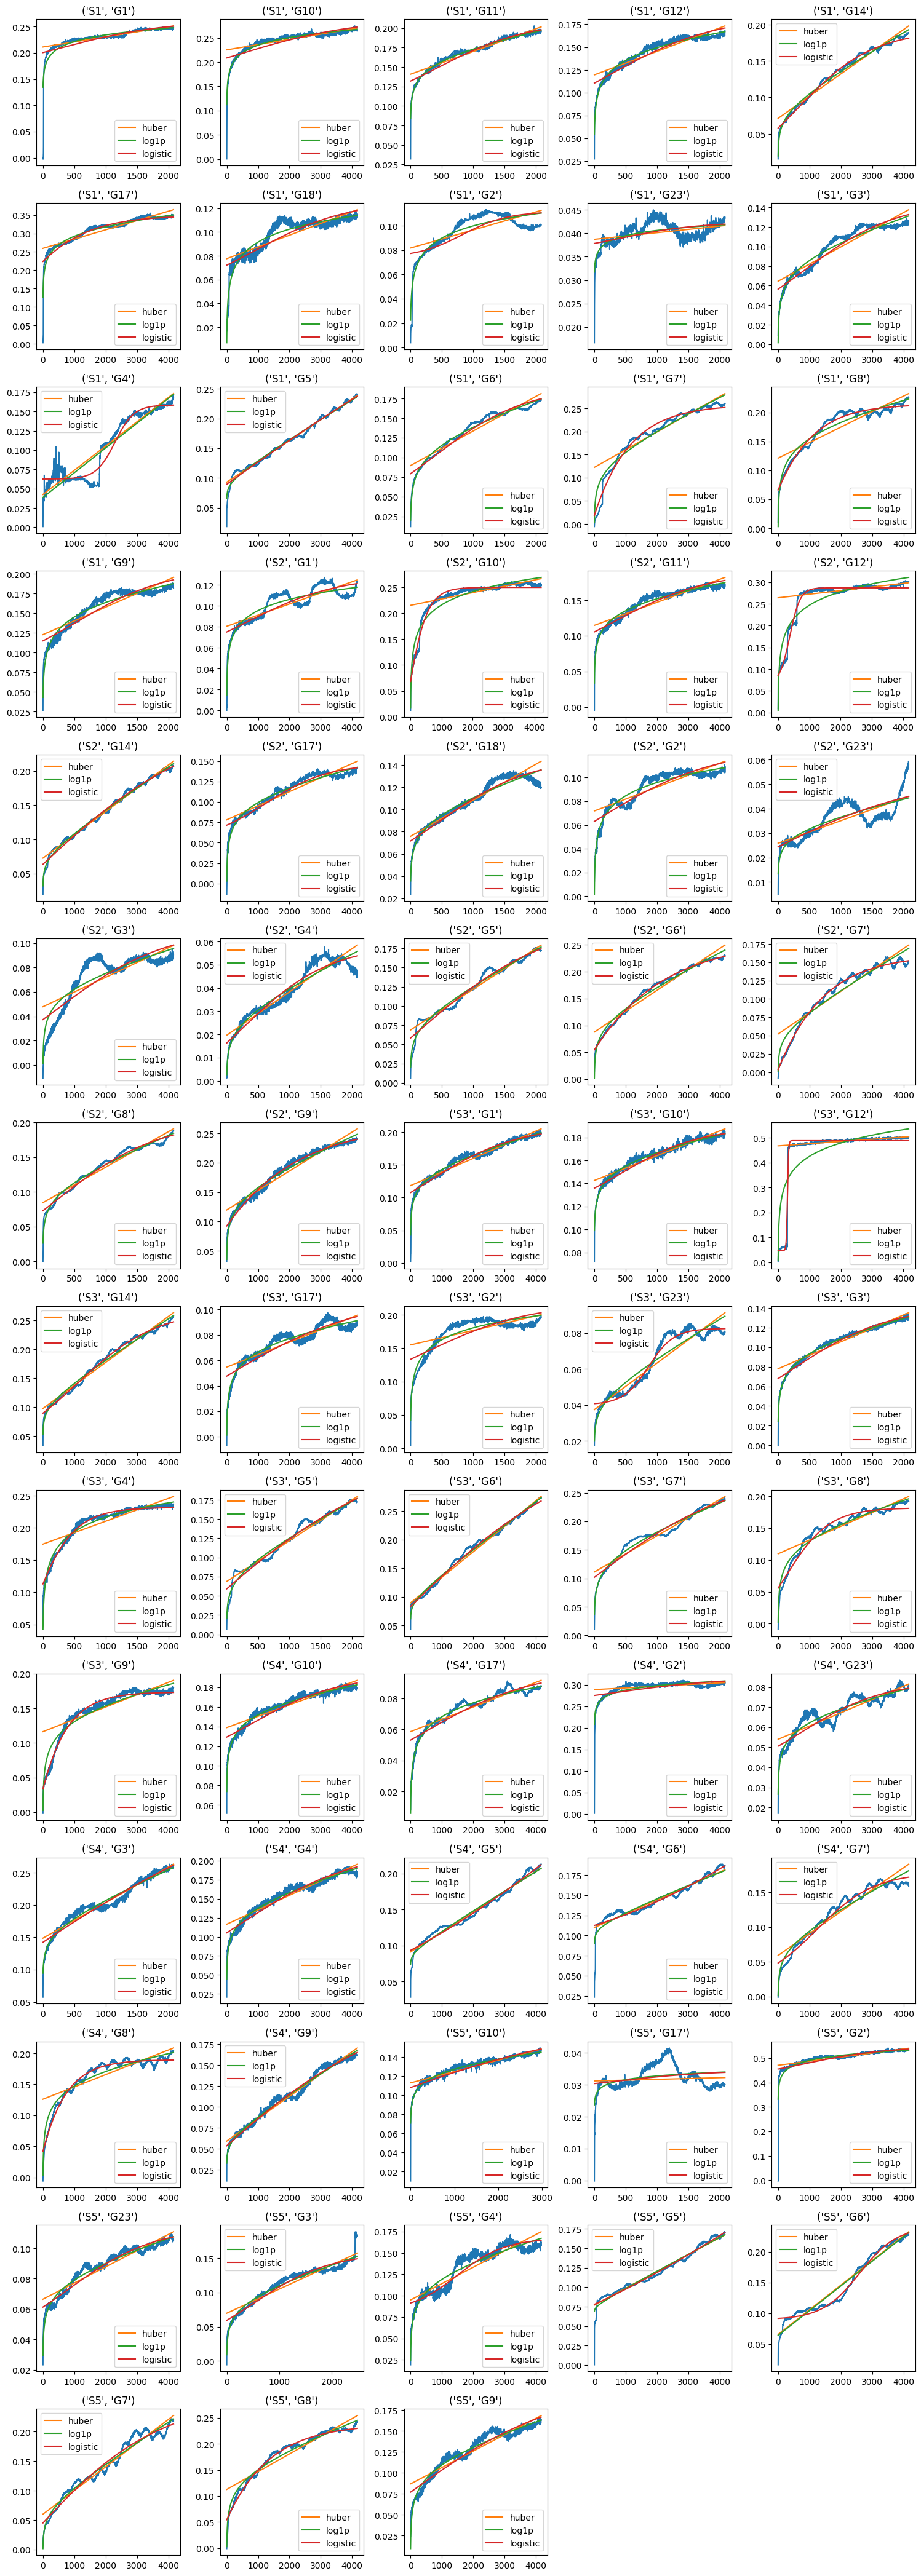

In [5]:
groups = dset.groupby(["sample", "material"])

n_cols = 5
n_rows = int(np.ceil(len(groups) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

for ax, key_group in zip_longest(axes.flat, groups):
    if key_group is None:
        ax.axis("off")
        continue

    key, group = key_group
    ax.set_title(key)
    ax.plot(group["Wear Loss [mm]"].values)

    for label, model in models.items():
        ypred = model(group)
        ax.plot(ypred, label=label)

    ax.legend()

fig.tight_layout()